# Rolling Averages in GameLogs

In this notebook we will add some rolling averages to both teams and players gamelogs. We'll start by analizing one team in a specific season and then apply the changes to all the gamelogs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import math

In [2]:
data_path = Path("~/MBAI/data").expanduser()

In [3]:
current_season_id = "22024"
current_season_path = data_path / f"rs{current_season_id}"

In [4]:
schedule_df = pd.read_parquet(current_season_path / "schedule.parquet")

In [5]:
dfs = [
    pd.read_parquet(game_dir / "teams_gamelog.parquet")
        for game_dir in current_season_path.iterdir()
            if game_dir.is_dir() and game_dir.name.startswith('g')
]

In [6]:
combined_df = pd.concat(dfs).drop('SEASON_ID', axis=1).reset_index(drop=True)

In [7]:
team_ids = combined_df['TEAM_ID'].unique()
current_team_id = team_ids[-1]

In [8]:
df = combined_df[combined_df['TEAM_ID'] == current_team_id].drop('TEAM_ID', axis=1)

In [9]:
df['GAME_ID']

142     22400483
149     22401082
150     22400112
236     22400514
261     22400193
          ...   
2362    22400926
2373    22400149
2393    22400127
2428    22401022
2452    22400468
Name: GAME_ID, Length: 82, dtype: uint32

In [10]:
schedule_df['GAME_ID'] = pd.to_numeric(schedule_df['GAME_ID'], downcast="unsigned")

In [11]:
team_schedule_df = schedule_df[schedule_df['GAME_ID'].isin(df['GAME_ID'])]

In [12]:
df = df.set_index('GAME_ID').sort_index()

In [13]:
df

/home/mrrobot/anaconda3/envs/MBAI/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
GAME_ID,,,,,,,,,,,,,,,,,,,,
22400008,True,240,43,84,0.512207,18,32,0.562988,18,20,0.899902,11,28,39,30,14,7,20,23,122
22400031,False,240,30,91,0.330078,11,43,0.256104,17,22,0.772949,13,32,45,17,9,8,21,20,88
22400049,True,240,46,90,0.511230,11,37,0.297119,12,15,0.799805,8,32,40,27,10,3,12,17,115
22400060,False,240,41,80,0.513184,10,29,0.344971,13,16,0.812988,11,18,29,25,6,4,18,15,105
22400072,False,240,36,92,0.391113,8,34,0.234985,24,30,0.799805,13,29,42,21,10,4,18,22,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22401162,False,265,48,104,0.461914,11,45,0.244019,19,28,0.679199,14,29,43,27,13,5,17,23,126
22401183,False,240,32,85,0.375977,6,30,0.199951,16,22,0.727051,13,39,52,21,9,5,22,20,86
22401199,True,240,42,96,0.437988,15,42,0.356934,10,21,0.476074,27,29,56,27,7,6,16,16,109


In [14]:
cols2avg = ['FGA', 'FG_PCT', 'FG3A', 'FG3_PCT', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

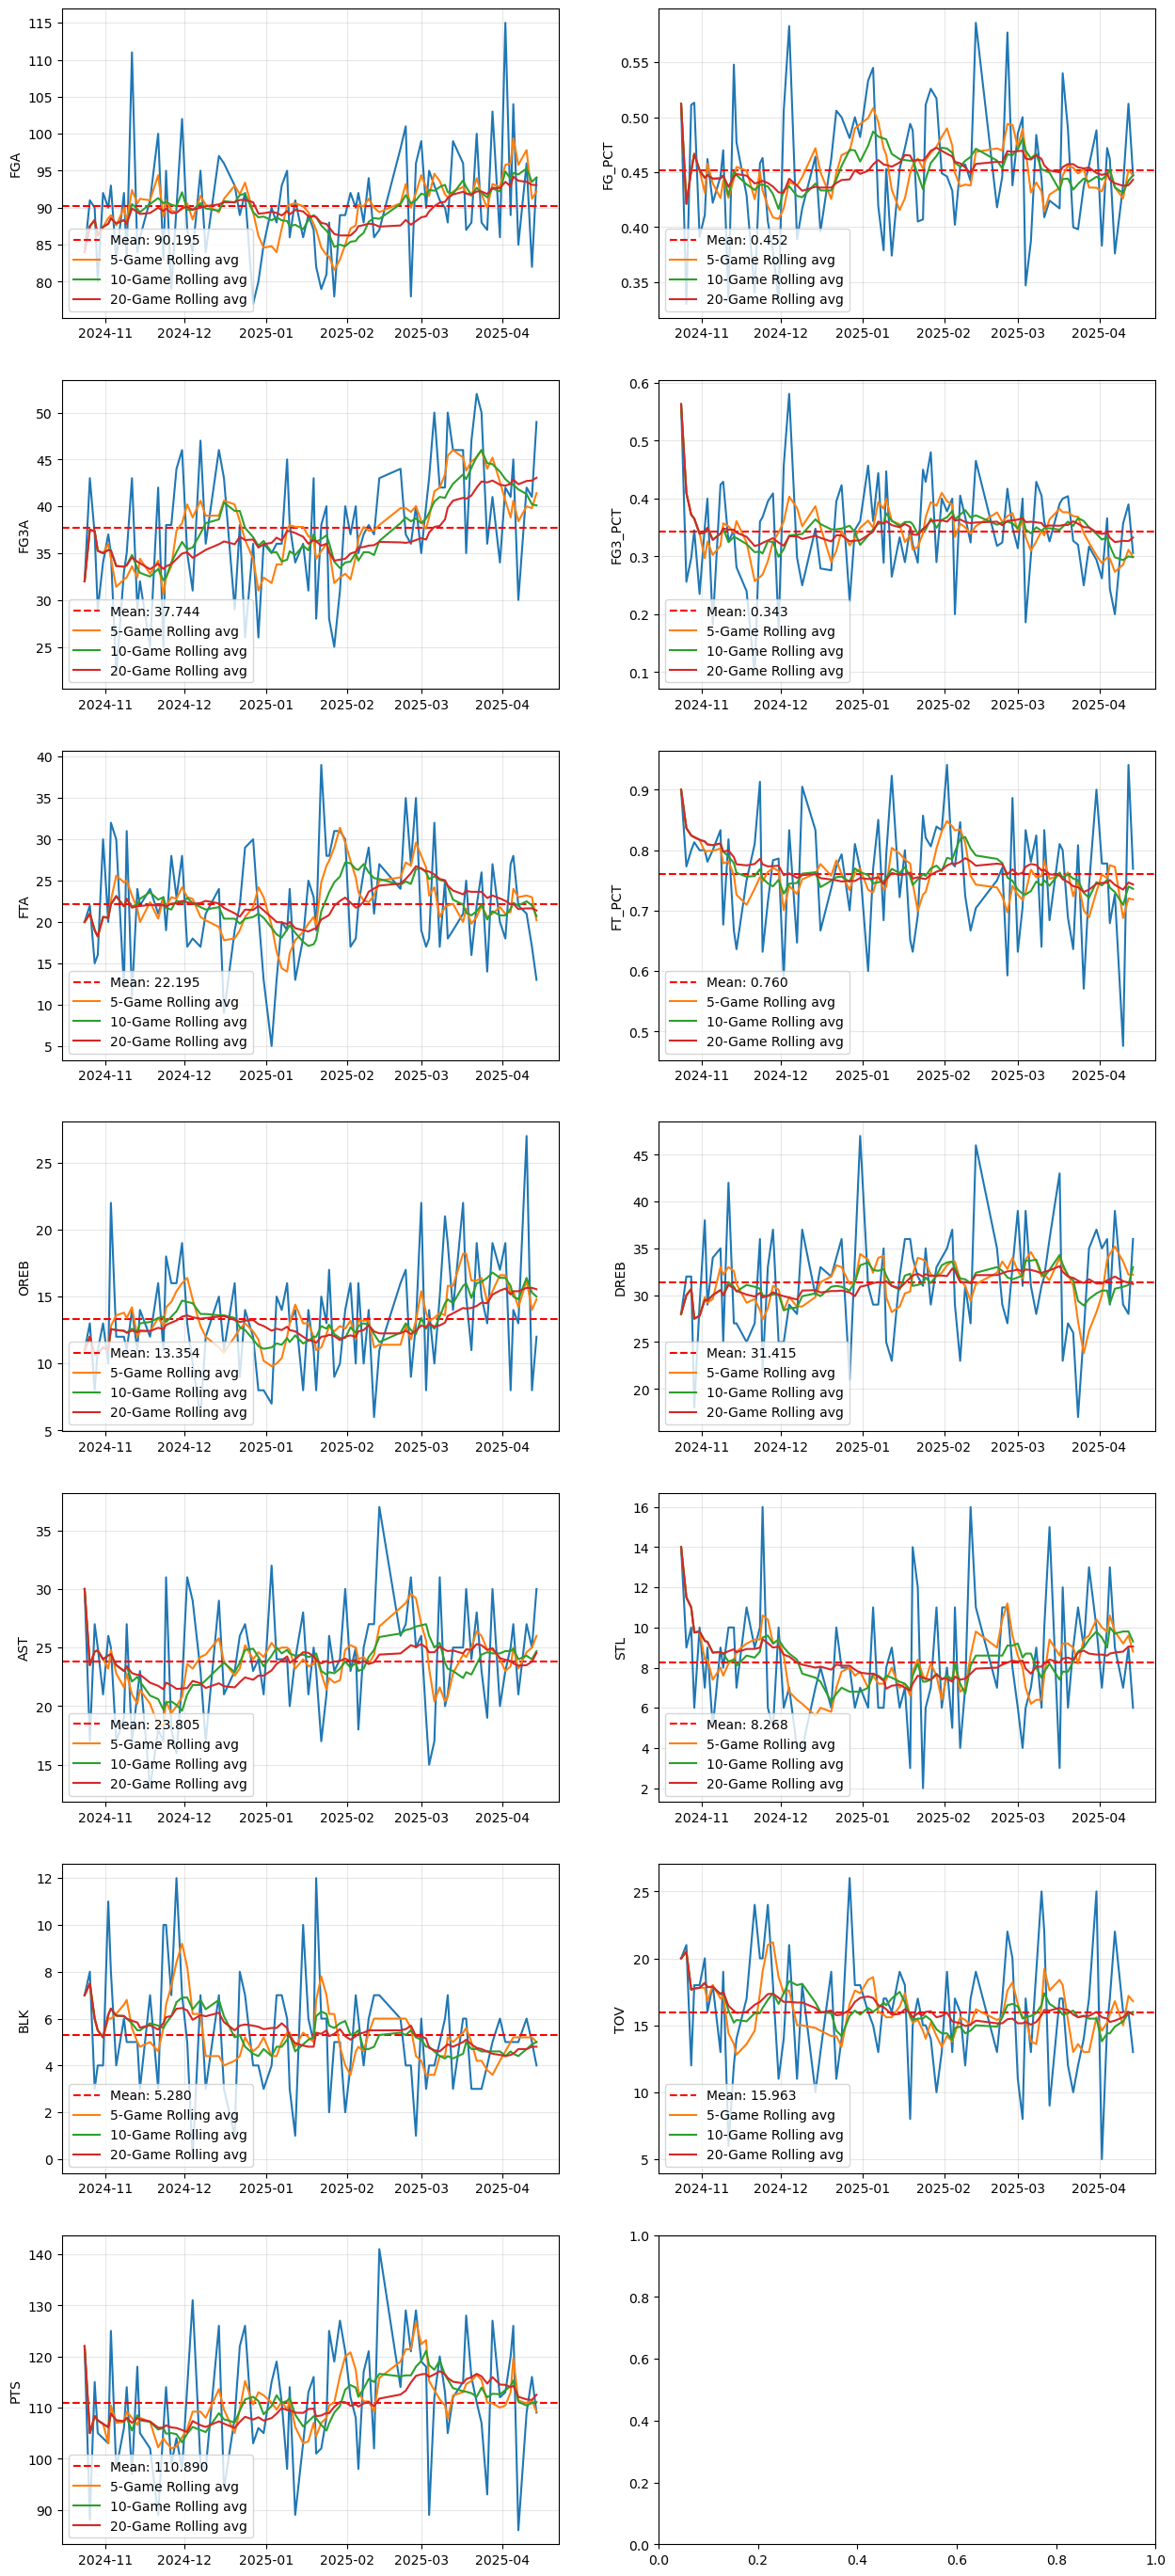

In [15]:
n_rows = math.ceil(len(cols2avg) / 2)
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
axes = axes.flatten() 

game_dates = team_schedule_df['GAME_DATE']
for i, col in enumerate(cols2avg):
    ax = axes[i]
    ax.set_ylabel(col)

    data = df[col]
    ax.plot(game_dates, data)
    
    mean = data.mean()
    ax.axhline(y=mean, color='red', linestyle='--', label=f'Mean: {mean:.3f}')

    avg5 = data.rolling(window=5, min_periods=1).mean()
    ax.plot(game_dates, avg5, label='5-Game Rolling avg')
    
    avg10 = data.rolling(window=10, min_periods=1).mean()
    ax.plot(game_dates, avg10, label='10-Game Rolling avg')

    avg20 = data.rolling(window=20, min_periods=1).mean()
    ax.plot(game_dates, avg20, label='20-Game Rolling avg')

    ax.legend(loc="lower left")
    ax.grid(True, alpha=0.3)
    
    ax.plot()

In [16]:
players_dfs = [
    pd.read_parquet(game_dir / "players_gamelog.parquet")
        for game_dir in current_season_path.iterdir()
            if game_dir.is_dir() and game_dir.name.startswith('g')
]

In [17]:
len(players_dfs)

1230

In [18]:
player_combined_df = pd.concat(players_dfs).drop('SEASON_ID', axis=1).reset_index(drop=True)

In [19]:
player_ids = player_combined_df['PLAYER_ID'].unique()
current_player_id = player_ids[300]

In [20]:
P_df = player_combined_df[player_combined_df['PLAYER_ID'] == current_player_id].drop('PLAYER_ID', axis=1)

In [21]:
player_schedule_df = schedule_df[schedule_df['GAME_ID'].isin(P_df['GAME_ID'])]

In [22]:
P_df = P_df.set_index('GAME_ID').sort_index()

In [23]:
P_df

,WL,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS
GAME_ID,,,,,,,,,,,,,,,,,,
22400001,True,31,7,11,1,4,0,0,4,2,6,2,0,0,3,4,15,15
22400012,True,26,5,9,0,2,3,3,4,9,13,0,2,2,3,2,13,9
22400030,False,21,3,9,0,2,1,2,0,6,6,1,0,0,0,0,7,-8
22400041,True,22,6,8,1,2,2,2,2,5,7,2,0,0,0,0,15,3
22400064,True,28,11,12,0,0,6,6,4,4,8,1,0,3,2,1,28,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22401149,False,40,9,17,4,7,8,8,7,7,14,4,3,0,2,4,30,-6
22401169,True,33,5,7,1,2,3,4,1,14,15,2,0,0,2,2,14,18
22401173,True,29,2,7,0,3,0,0,1,7,8,1,1,1,4,5,4,1


In [24]:
cols2avg = ['FGA', 'FG3A', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

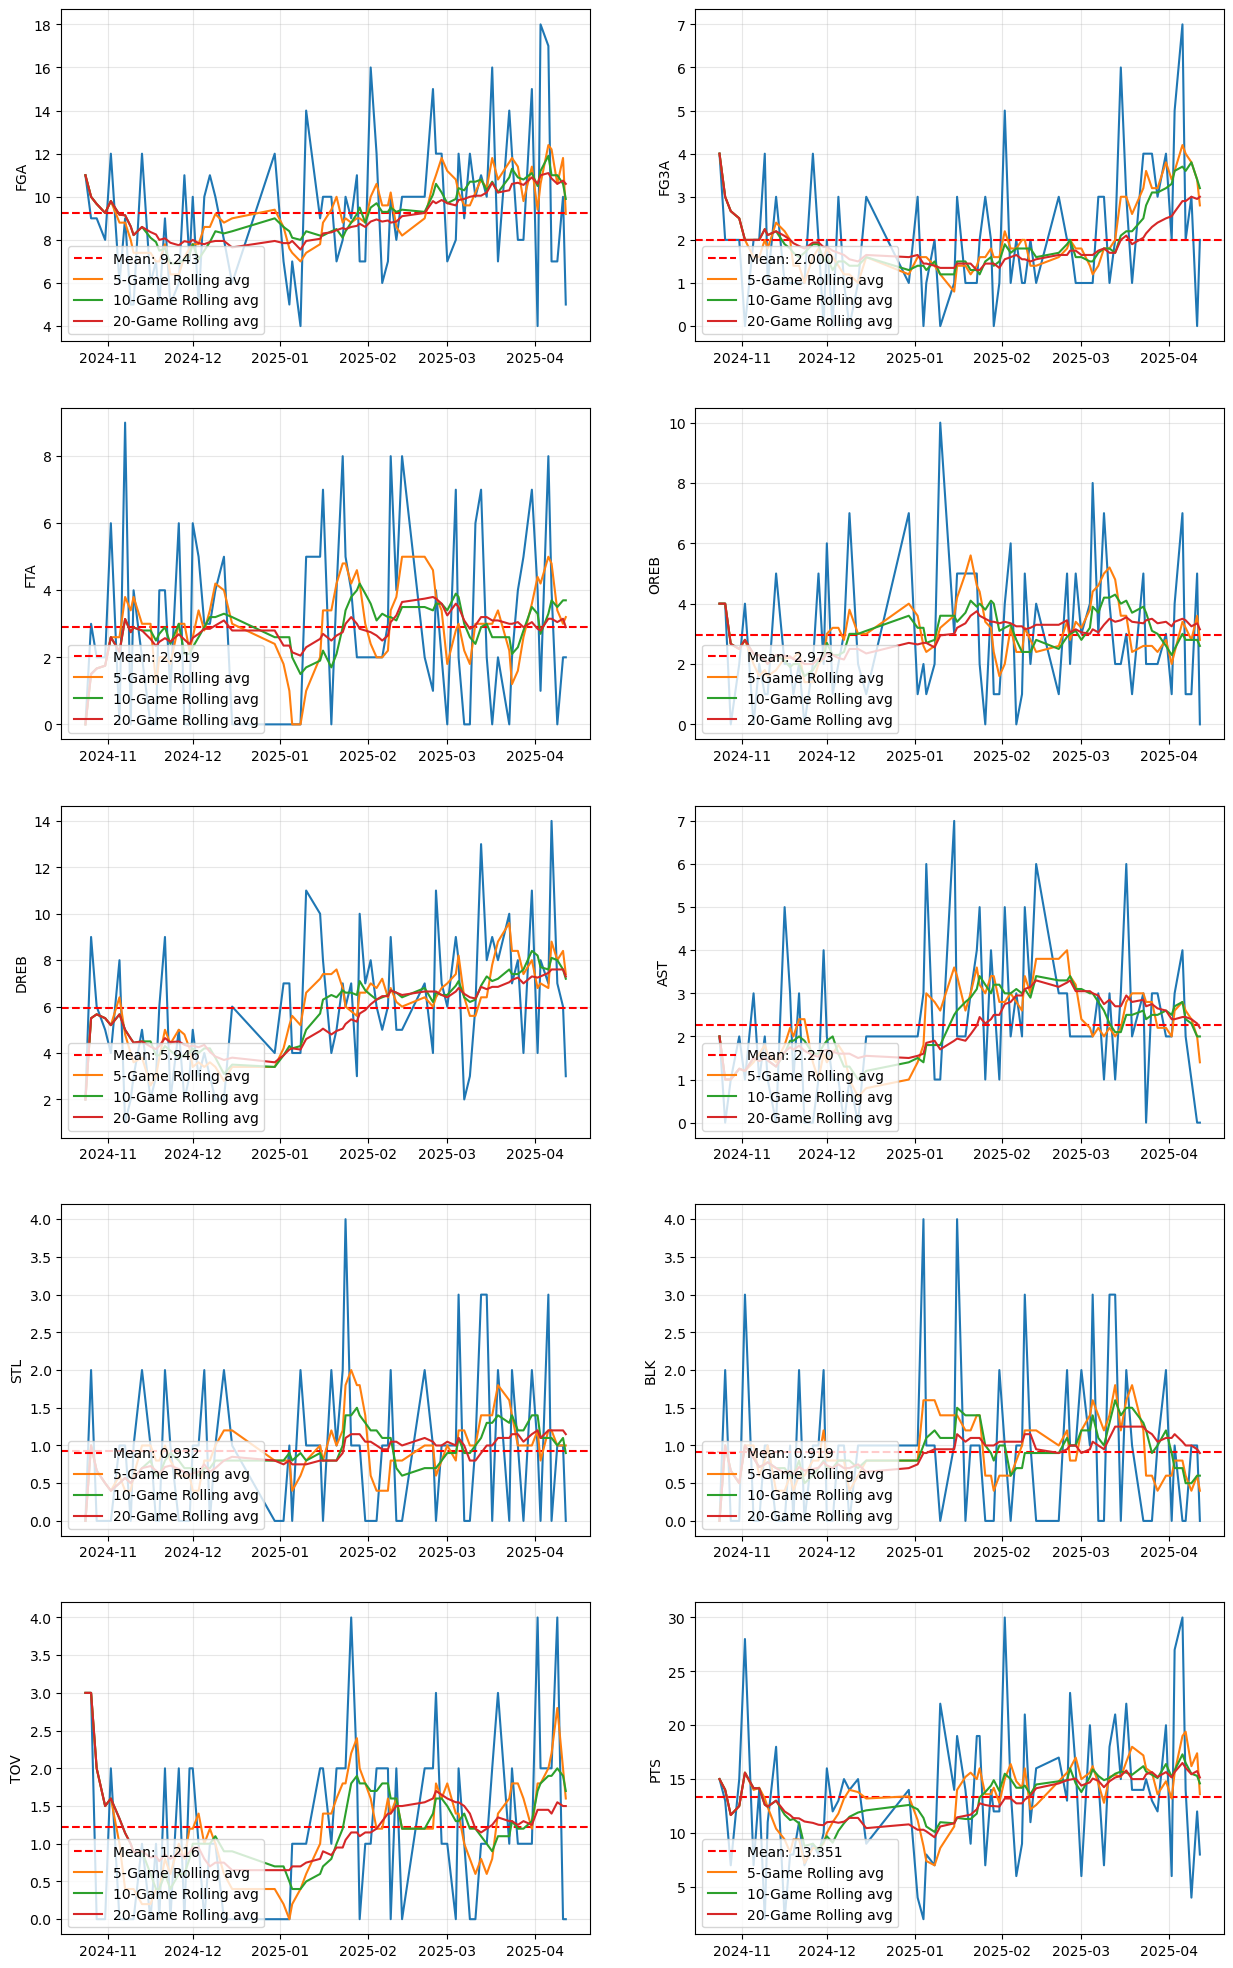

In [25]:
n_rows = math.ceil(len(cols2avg) / 2)
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
axes = axes.flatten() 

game_dates = player_schedule_df['GAME_DATE']

for i, col in enumerate(cols2avg):
    ax = axes[i]
    ax.set_ylabel(col)

    data = P_df[col]
    ax.plot(game_dates, data)
    
    mean = data.mean()
    ax.axhline(y=mean, color='red', linestyle='--', label=f'Mean: {mean:.3f}')

    avg5 = data.rolling(window=5, min_periods=1).mean()
    ax.plot(game_dates, avg5, label='5-Game Rolling avg')
    
    avg10 = data.rolling(window=10, min_periods=1).mean()
    ax.plot(game_dates, avg10, label='10-Game Rolling avg')

    avg20 = data.rolling(window=20, min_periods=1).mean()
    ax.plot(game_dates, avg20, label='20-Game Rolling avg')

    ax.legend(loc="lower left")
    ax.grid(True, alpha=0.3)
    
    ax.plot()